# --- Imports and Setup ---

In [ ]:
from tqdm.auto import tqdm
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Datasets/magnitute_function/magnitude')
from magnitude_function import *

# --- Load Data ---
# pre-computed embeddings and their labels (0 = real, 1 = generated).

I have run python get_embeddings.py code in the 'data_preprocessing' directory to get embeddings and store them in google colab

In [ ]:
EMB_PATH = "/content/drive/MyDrive/Datasets/magnitute_function/magnitude/embeddings.pt"
LAB_PATH = "/content/drive/MyDrive/Datasets/magnitute_function/magnitude/labels.pt"

embs = torch.load(EMB_PATH)
labs = torch.load(LAB_PATH)

In [ ]:
reals_inds = torch.where(labs == 0)[0]
generated_inds = torch.where(labs == 1)[0]

reals = embs[reals_inds]
gens = embs[generated_inds]


# --- Calculate Magnitude (single t value) ---

In [ ]:
t = 0.1

start = time.time()
real_mags = [calculate_magnitude(x * t, metric='cityblock') for x in tqdm(reals, desc="Real (Exact)")]
end = time.time()
real_exact_time = end - start

start = time.time()
gen_mags = [calculate_magnitude(x * t, metric='cityblock') for x in tqdm(gens, desc="Gen (Exact)")]
end = time.time()
gen_exact_time = end - start

Real (Exact):   0%|          | 0/500 [00:00<?, ?it/s]

Gen (Exact):   0%|          | 0/500 [00:00<?, ?it/s]

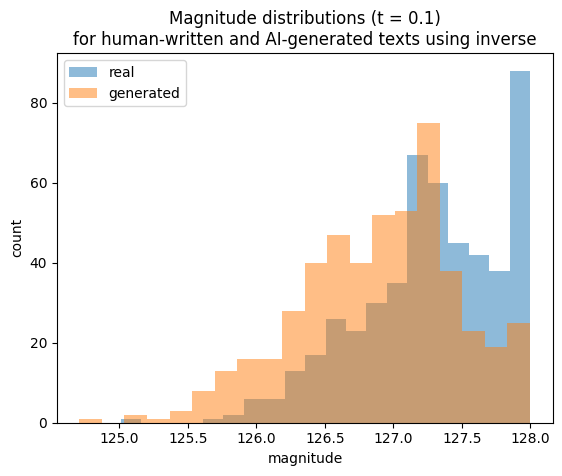

In [ ]:
plt.hist(real_mags, alpha=0.5, label='real', bins=20)
plt.hist(gen_mags, alpha=0.5, label='generated', bins=20)
plt.legend()
plt.title(f"Magnitude distributions (t = {t})\nfor human-written and AI-generated texts using inverse")
plt.xlabel("magnitude")
plt.ylabel('count')
plt.show()

# --- Calculate Magnitude Functions (as a function of t, for each text)

In [ ]:
t = np.linspace(0.005, 0.04, 50)

In [ ]:
real_mfs = []
for x in tqdm(reals, desc="Real magnitude", position=0, leave=True):
    real_mfs.append(calculate_magnitude_function(x, 'cityblock', t))

gen_mfs = []
for x in tqdm(gens, desc="Generated magnitude", position=1, leave=True):
    gen_mfs.append(calculate_magnitude_function(x, 'cityblock', t))

Real magnitude:   0%|          | 0/500 [00:00<?, ?it/s]

Generated magnitude:   0%|          | 0/500 [00:00<?, ?it/s]

# --- Plot Magnitude Function Curves (real vs generated) ---

Text(0, 0.5, 'magnitude')

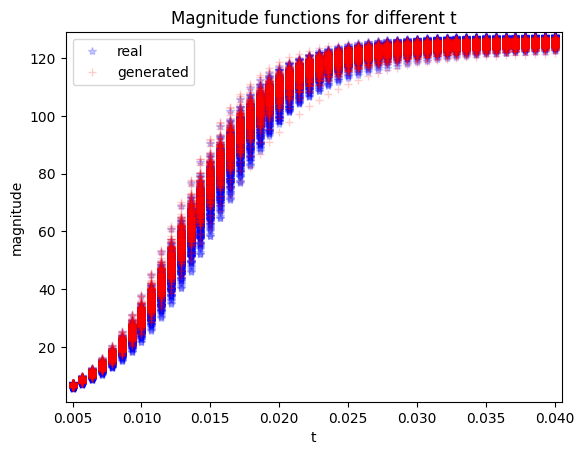

In [ ]:
plt.title("Magnitude functions for different t")
l1 = plt.plot(t, np.array(real_mfs).T, 'b*', alpha=0.2, label='real')
l2 = plt.plot(t, np.array(gen_mfs).T,  "r+", alpha=0.2, label='generated')
plt.legend(handles=[l1[0], l2[0]])
plt.xlim(0.0045, 0.0405)
plt.ylim(1, 129)
plt.xlabel("t")
plt.ylabel("magnitude")

# --- Logistic Regression Classifier ---

In [ ]:
from classification_utils import logreg, logreg_and_find_generated_misclassifications

df_small = pd.read_csv(r"/content/drive/MyDrive/Datasets/magnitute_function/magnitude/small_data.csv")

all_texts   = df_small["text"].to_numpy()
all_sources = df_small["source"].to_numpy()

real_idx = reals_inds.numpy()
gen_idx  = generated_inds.numpy()

real_texts   = all_texts[real_idx]
gen_texts    = all_texts[gen_idx]
real_sources = all_sources[real_idx]
gen_sources  = all_sources[gen_idx]

# --- Classification: Magnitude Curves as Features ---



*  Trained a classifier using only the magnitude function features.
*  Trained a separate classifier using just the mean embeddings.
*  Also trained a classifier usiyg a combination of both magnitude function features and mean embeddings.
*  Have check some mistakes done by each












In [ ]:
auc_magnitude_no_pca = logreg(real_mfs, gen_mfs, pca=False)
auc_magnitude_pca = logreg(real_mfs, gen_mfs, pca=True)
print(f"Magnitude-only AUC without PCA: {auc_magnitude_no_pca:.4f}")
print(f"Magnitude-only AUC with PCA: {auc_magnitude_pca:.4f}")

Magnitude-only AUC without PCA: 0.7907
Magnitude-only AUC with PCA: 0.7907


In [ ]:
mistakes_magnitude = logreg_and_find_generated_misclassifications(real_mfs, gen_mfs,real_texts, gen_texts,real_sources, gen_sources,pca=False)

Mean CV AUC: 0.7907
Generated→Real misclassifications: 157

Some examples:
[chat_gpt_moth] Taking a class in a classroom setting as opposed to taking one online can offer a variety of distinc…

[darragh_claude_v7] When facing an important decision, it is wise to get perspectives from various people. Each person w…

[chat_gpt_moth] It is commonly held belief that to be successful, one must always be busy doing something. This idea…

[mistral7binstruct_v1] to achieve success in life.

Having a positive attitude is an essential aspect of achieving success …

[chat_gpt_moth] Self-esteem is an important factor in any student’s academic success and overall well-being. There a…



In [ ]:
real_text_embs = reals.mean(dim=1).numpy()
gen_text_embs = gens.mean(dim=1).numpy()

auc_no_emb_pca  = logreg(real_text_embs, gen_text_embs, pca=False)
auc_with_emb_pca = logreg(real_text_embs, gen_text_embs, pca=True)
print(f"Mean‐embedding AUC (no PCA): {auc_no_emb_pca:.4f}")
print(f"Mean‐embedding AUC (with PCA): {auc_with_emb_pca:.4f}")

Mean‐embedding AUC (no PCA): 0.9908
Mean‐embedding AUC (with PCA): 0.9907


In [ ]:
mistakes_emb = logreg_and_find_generated_misclassifications(real_text_embs,gen_text_embs,real_texts,gen_texts,real_sources,gen_sources,pca=False)

Mean CV AUC: 0.9908
Generated→Real misclassifications: 19

Some examples:
[chat_gpt_moth] Before making any decisions about getting involved in school activities, it is important to consult …

[chat_gpt_moth] Starting a homework club at a middle school could be beneficial for students by helping them stay on…

[llama2_chat] Hey there!  So, the telephone. Like, who would have thought that talking to someone over a distance …

[cohere-command]  Limiting car usage: Staying put for the sake of our planet

It appears that the harmful effects of …

[chat_gpt_moth] When faced with a problem, it's easy to become overwhelmed or to give up too quickly. However, this …



In [ ]:
real_text_and_mag = np.concatenate([real_text_embs, real_mfs], axis=1)
gen_text_and_mag = np.concatenate([gen_text_embs, gen_mfs], axis=1)

auc_no_pca, auc_pca = (
    logreg(real_text_and_mag, gen_text_and_mag, pca=False),
    logreg(real_text_and_mag, gen_text_and_mag, pca=True)
)
print(f"Combined embeddings and magnitude AUC (no PCA): {auc_no_pca:.4f}")
print(f"Combined embeddings and magnitude AUC (with PCA): {auc_pca:.4f}")

Combined embeddings and magnitude AUC (no PCA): 0.9911
Combined embeddings and magnitude AUC (with PCA): 0.9909


In [ ]:
mistakes = logreg_and_find_generated_misclassifications(real_text_and_mag,gen_text_and_mag,real_texts,gen_texts,real_sources,gen_sources,pca=False)

Mean CV AUC: 0.9911
Generated→Real misclassifications: 16

Some examples:
[chat_gpt_moth] Before making any decisions about getting involved in school activities, it is important to consult …

[llama_70b_v1] Drivers should not be able to use cell phones in any capacity while operating a vehicle. Like, I mea…

[chat_gpt_moth] Starting a homework club at a middle school could be beneficial for students by helping them stay on…

[cohere-command]  Limiting car usage: Staying put for the sake of our planet

It appears that the harmful effects of …

[falcon_180b_v1] "Making Mona Lisa Smile" is an article that talks about the Facial Action Coding System (FACS) which…



# --- Study Magnitude vs Text Length ---

In [ ]:
t0 = 0.02
lengths = np.array([len(str(text).split()) for text in df_small['text']])
magnitudes = np.array([
    calculate_magnitude(embs[i].numpy() * t0, metric='cityblock')
    for i in range(len(df_small))
])

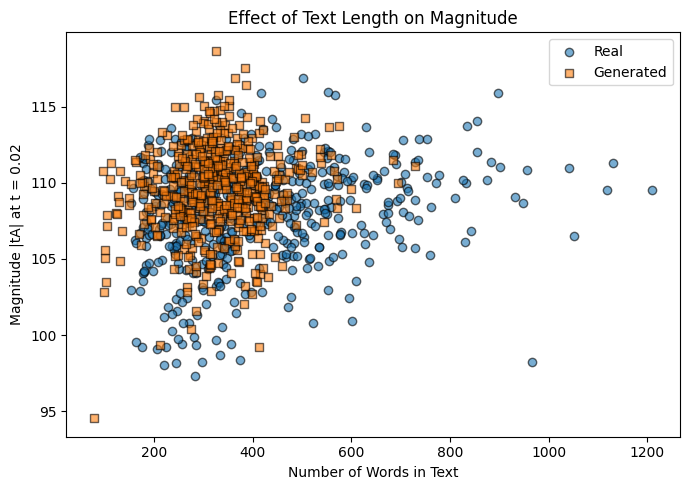

In [ ]:
plt.figure(figsize=(7, 5))
plt.scatter(lengths[reals_inds], magnitudes[reals_inds],
            alpha=0.6, label='Real', edgecolor='k')
plt.scatter(lengths[generated_inds], magnitudes[generated_inds],
            alpha=0.6, label='Generated', marker='s', edgecolor='k')

plt.xlabel("Number of Words in Text")
plt.ylabel(f"Magnitude |tA| at t = {t0}")
plt.title("Effect of Text Length on Magnitude")
plt.legend()
plt.tight_layout()
plt.show()

**real data is more spread out**

In [ ]:
sys.path.append('/path/to/the/directory/containing')
from max_length_exp import run_max_length_experiment_curves
import matplotlib.pyplot as plt

# --- Max Length Experiment: How window size affects AUC ---

In [ ]:
df_res = run_max_length_experiment_curves(
    small_csv = r"/content/drive/MyDrive/Datasets/magnitute_function/magnitude/small_data.csv",
    lab_path  = r"/content/drive/MyDrive/Datasets/magnitute_function/magnitude/labels.pt",
    max_lengths=[32,64,128,256],
    T=np.linspace(0.005,0.04,50),
    metric="cityblock",
    pca=False
)

max_length sweep:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Real curves L=32:   0%|          | 0/500 [00:00<?, ?it/s]

Gen curves  L=32:   0%|          | 0/500 [00:00<?, ?it/s]

Real curves L=64:   0%|          | 0/500 [00:00<?, ?it/s]

Gen curves  L=64:   0%|          | 0/500 [00:00<?, ?it/s]

Real curves L=128:   0%|          | 0/500 [00:00<?, ?it/s]

Gen curves  L=128:   0%|          | 0/500 [00:00<?, ?it/s]

Real curves L=256:   0%|          | 0/500 [00:00<?, ?it/s]

Gen curves  L=256:   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
print(df_res)

   max_length       auc
0          32  0.670274
1          64  0.722952
2         128  0.790646
3         256  0.839195


**As max_length increases, accuracy increases**

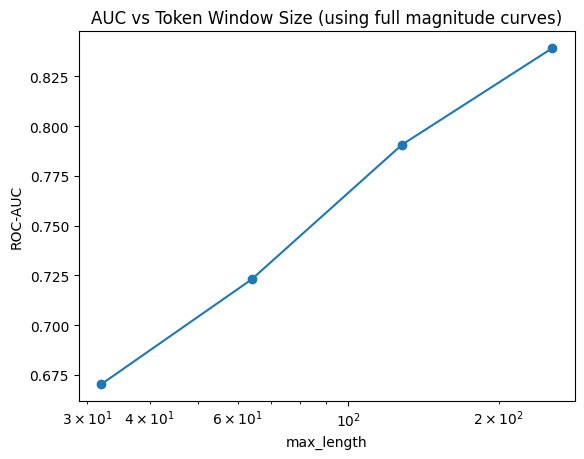

In [ ]:
plt.plot(df_res.max_length, df_res.auc, '-o')
plt.xscale('log')
plt.xlabel('max_length')
plt.ylabel('ROC-AUC')
plt.title('AUC vs Token Window Size (using full magnitude curves)')
plt.show()

# --- Augment Feature Set: Add statistical and geometric info from curves ---

In [ ]:
import numpy as np
from magnitude_function import calculate_dimension

def augment_features(mfs: np.ndarray, t: np.ndarray) -> np.ndarray:
    N, M = mfs.shape
    dims = np.stack([calculate_dimension(curve, t) for curve in mfs], axis=0)

    auc  = np.trapz(mfs, x=t, axis=1)

    peak     = mfs.max(axis=1)
    t_peak   = t[np.argmax(mfs, axis=1)]

    slope_small = dims[:, 0]
    slope_large = dims[:, -1]

    mean_val  = mfs.mean(axis=1)
    std_val   = mfs.std(axis=1)
    skewness  = ((mfs - mean_val[:,None])**3).mean(axis=1) / (std_val**3 + 1e-9)

    extras = np.stack([auc, peak, t_peak, slope_small, slope_large, mean_val, std_val, skewness], axis=1)

    return np.hstack([mfs, dims, extras])

In [ ]:
real_arr = np.array(real_mfs)
gen_arr  = np.array(gen_mfs)

X_real = augment_features(real_arr, t)
X_gen  = augment_features(gen_arr,  t)

auc_aug = logreg(X_real, X_gen, pca=False)
print(f"Augmented features AUC: {auc_aug:.4f}")

Augmented features AUC: 0.8131


<ipython-input-15-ee6c635e9746>:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc  = np.trapz(mfs, x=t, axis=1)            # (N,)


**Accuracy is increased from 79% to 81%**

**Should then experiment with more features**

# --- Try Higher-Resolution Magnitude Curves (128 t values) ---

In [ ]:
T = np.linspace(0.005, 0.04, 128)

In [ ]:
real_mfs_128 = []
for x in tqdm(reals, desc="Real magnitude (128 pts)"):
    real_mfs_128.append(calculate_magnitude_function(x, 'cityblock', T))

Real magnitude (128 pts):   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
gen_mfs_128 = []
for x in tqdm(gens, desc="Gen magnitude (128 pts)"):
    gen_mfs_128.append(calculate_magnitude_function(x, 'cityblock', T))

Gen magnitude (128 pts):   0%|          | 0/500 [00:00<?, ?it/s]

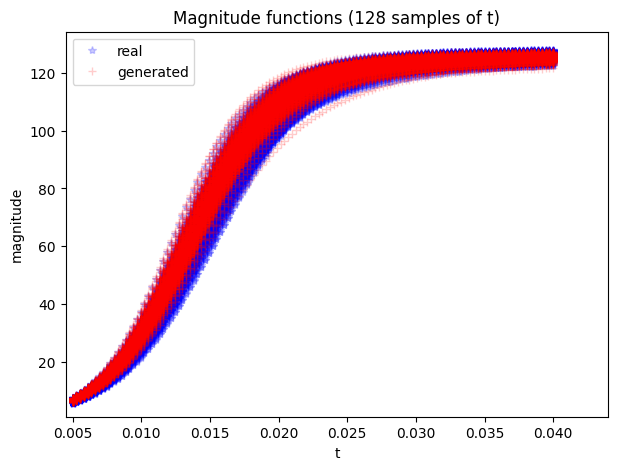

In [ ]:
plt.figure(figsize=(7, 5))
plt.title("Magnitude functions (128 samples of t)")
l1 = plt.plot(T, np.array(real_mfs_128).T, 'b*', alpha=0.2, label='real')
l2 = plt.plot(T, np.array(gen_mfs_128).T,  'r+', alpha=0.2, label='generated')
plt.legend(handles=[l1[0], l2[0]])
plt.xlim(T[0]*0.9, T[-1]*1.1)
plt.ylim(1, max(np.array(real_mfs_128).max(), np.array(gen_mfs_128).max()) * 1.05)
plt.xlabel("t")
plt.ylabel("magnitude")
plt.show()

In [ ]:
auc_no_pca_128  = logreg(real_mfs_128, gen_mfs_128, pca=False)
auc_pca_128     = logreg(real_mfs_128, gen_mfs_128, pca=True)
print(f"124-point magnitude AUC without PCA: {auc_no_pca_128:.4f}")
print(f"124-point magnitude AUC with PCA:    {auc_pca_128:.4f}")

124-point magnitude AUC without PCA: 0.7924
124-point magnitude AUC with PCA:    0.7926


In [ ]:
print(len(gens))

500


**Accuracy donot change when we train classifier on more features from 50 to 128.**

# --- Fast Magnitude Calculation (with conjugate gradients) ---

In [ ]:
t= 0.1
start = time.time()
real_mags_cg = [gradient_z_inverse(x * t, metric='cityblock') for x in tqdm(reals, desc="Real (CG)")]
end = time.time()
real_cg_time = end - start

Real (CG):   0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
start = time.time()
gen_mags_cg = [gradient_z_inverse(x * t, metric='cityblock') for x in tqdm(gens, desc="Gen (CG)")]
end = time.time()
gen_cg_time = end - start

Gen (CG):   0%|          | 0/500 [00:00<?, ?it/s]

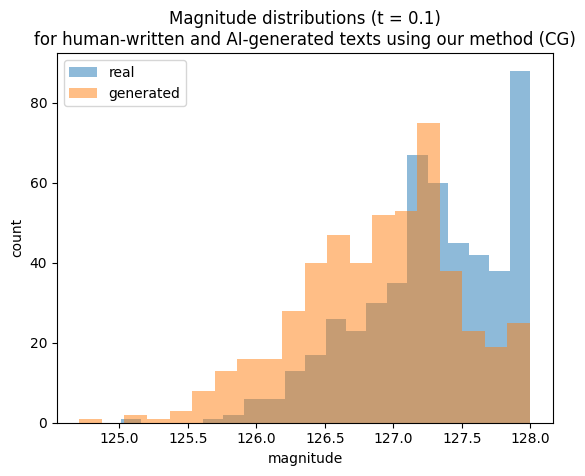

In [ ]:
plt.hist(real_mags_cg, alpha=0.5, label='real', bins=20)
plt.hist(gen_mags_cg, alpha=0.5, label='generated', bins=20)
plt.legend()
plt.title(f"Magnitude distributions (t = {t})\nfor human-written and AI-generated texts using our method (CG)")
plt.xlabel("magnitude")
plt.ylabel('count')
plt.show()

**As we can see from above graph output is same**

# --- Timing summary: matrix inversion vs gradient-based method ---

In [ ]:
print("\n--- Time Taken Summary ---")
print(f"Real (Exact): {real_exact_time:.3f} seconds, per sample: {real_exact_time / len(reals):.4f}s")
print(f"Gen  (Exact): {gen_exact_time:.3f} seconds, per sample: {gen_exact_time / len(gens):.4f}s")
print(f"Real (CG):    {real_cg_time:.3f} seconds, per sample: {real_cg_time / len(reals):.4f}s")
print(f"Gen  (CG):    {gen_cg_time:.3f} seconds, per sample: {gen_cg_time / len(gens):.4f}s")


--- Time Taken Summary ---
Real (Exact): 8.367 seconds, per sample: 0.0167s
Gen  (Exact): 9.867 seconds, per sample: 0.0197s
Real (CG):    5.571 seconds, per sample: 0.0111s
Gen  (CG):    6.085 seconds, per sample: 0.0122s


**gradient based method speed is 1.5x time more**

# --- Check Error Between Inverse and CG Approaches for Random 2D Point Clouds ---

In [ ]:
sizes = [5, 10, 20, 30, 50, 75, 100, 150, 200,1000]
results = []

for n in sizes:
    points = np.random.rand(n, 2)

    start_time = time.time()
    mag_inv = calculate_magnitude(points, metric="euclidean")
    time_inv = time.time() - start_time

    start_time = time.time()
    mag_cg = gradient_z_inverse(points, metric="euclidean")
    time_cg = time.time() - start_time

    error = abs(mag_inv - mag_cg)
    results.append((n, mag_inv, mag_cg, error, time_inv, time_cg))

In [ ]:
import pandas as pd
df = pd.DataFrame(results, columns=["n", "Magnitude (inv)", "Magnitude (CG)", "Error", "Time (inv)", "Time (CG)"])
print(df.to_string(index=False))

   n  Magnitude (inv)  Magnitude (CG)        Error  Time (inv)  Time (CG)
   5         1.440985        1.440985 1.899370e-12    0.001365   0.000548
  10         1.661299        1.661299 6.794565e-13    0.000114   0.001023
  20         1.763742        1.763742 2.553917e-08    0.000107   0.000274
  30         1.886219        1.886219 2.980976e-07    0.000095   0.000402
  50         1.887036        1.887036 4.250486e-08    0.000263   0.000576
  75         1.886892        1.886892 7.857390e-08    0.000558   0.000708
 100         1.951446        1.951446 3.059767e-07    0.001146   0.001486
 150         2.027088        2.027088 1.058144e-07    0.002534   0.002347
 200         2.028111        2.028111 2.894916e-08    0.004267   0.003303
1000         2.048975        2.048975 4.018476e-07    0.151420   0.096589
